In [169]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from scikeras.wrappers import KerasClassifier
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from newsapi import NewsApiClient
import string
import spacy

In [170]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Download spaCy model
spacy.cli.download("en_core_web_sm")

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Read CSV
df = pd.read_csv("csv_file/data.csv")

# Extract texts and labels
texts = df["headlines"]
labels = df["outcome"]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\soder\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [172]:
# Preprocessing
def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    
    # Tokenization using spaCy
    tokens = nlp(text)
    tokens = [token.text for token in tokens]
    
    # Punctuation Removal
    tokens = [token for token in tokens if token not in string.punctuation]
    
    # Stop Word Removal
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return tokens


# Apply preprocessing to all texts
preprocessed_texts = [preprocess_text(text) for text in texts]

# Tokenization using Keras Tokenizer
max_words = 12200
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(preprocessed_texts)
sequences = tokenizer.texts_to_sequences(preprocessed_texts)

# Padding sequences
maxlen = 75
X = pad_sequences(sequences, maxlen=maxlen)

# Convert labels to numpy array
y = np.array(labels)

In [173]:
# Build the RNN model
embedding_dim = 50  # Dimensionality of the embedding space
hidden_units = 50  # Number of LSTM units

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Train the model
epochs = 5
batch_size = 32

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/5
204/204 [==============================] - 9s 39ms/step - loss: 0.2145 - accuracy: 0.9516 - val_loss: 0.1792 - val_accuracy: 0.9510
Epoch 2/5
204/204 [==============================] - 7s 37ms/step - loss: 0.1063 - accuracy: 0.9657 - val_loss: 0.1172 - val_accuracy: 0.9694
Epoch 3/5
204/204 [==============================] - 8s 37ms/step - loss: 0.0346 - accuracy: 0.9902 - val_loss: 0.1112 - val_accuracy: 0.9657
Epoch 4/5
204/204 [==============================] - 8s 37ms/step - loss: 0.0161 - accuracy: 0.9962 - val_loss: 0.1277 - val_accuracy: 0.9694
Epoch 5/5
64/64 [==============================] - 1s 14ms/step - loss: 0.1126 - accuracy: 0.9701
Test Accuracy: 97.01%


64/64 [==============================] - 1s 13ms/step


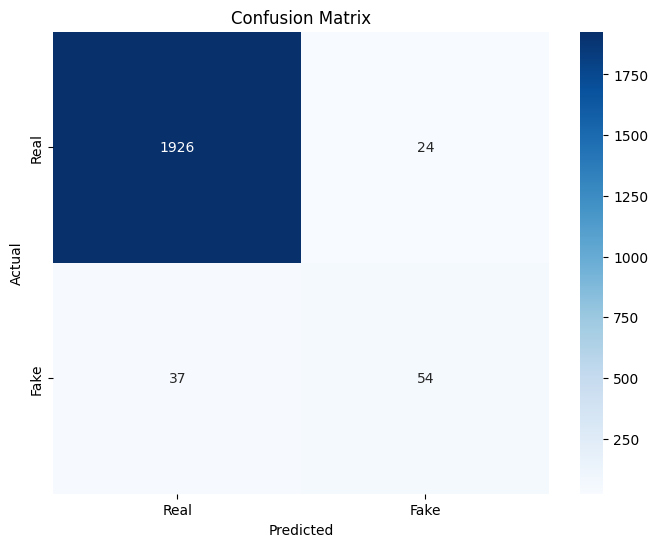

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1950
           1       0.69      0.59      0.64        91

    accuracy                           0.97      2041
   macro avg       0.84      0.79      0.81      2041
weighted avg       0.97      0.97      0.97      2041



In [188]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Display classification report
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

In [189]:
newsapi = NewsApiClient(api_key='2ec72918ca08491b885785649a92cfb7')
covid_articles = newsapi.get_everything(q='covid',
                                        language='en',
                                        sort_by='relevancy',
                                        page=1)

clean_title = []
for index, i in enumerate(covid_articles['articles']):
    row = i['title']
    row = row.split(" ")
    row = ' '.join(letter for letter in row if letter.isalnum() or letter == "COVID-19")
    if "COVID-19" in row:
        row = row.replace("COVID-19", "COVID19")
    row = row.lower()
    clean_title.append(row)

In [190]:
preprocessed_title = [preprocess_text(text) for text in clean_title]

In [191]:
new_sequences = tokenizer.texts_to_sequences(preprocessed_title)
new_padded_sequence = pad_sequences(new_sequences, maxlen=maxlen)

In [192]:
predictions = model.predict(new_padded_sequence)

4/4 [==============================] - 0s 12ms/step


In [193]:
threshold = 0.5

In [180]:
binary_predictions = (predictions >= threshold).astype(int)

In [194]:
for index, title in enumerate(clean_title):
    prediction = binary_predictions[index]
    if prediction == 1:
        prediction = "Real"
    else:
        prediction = "Fake"
    print(f"Title: {title}")
    print(f"Prediction: {prediction}")
    print("=" * 50)

Title: pneumonia in china is mix of common respiratory who says
Prediction: Real
Title: google shutters the covid19 exposure notification feature on android
Prediction: Real
Title: who seeks china data on in children
Prediction: Real
Title: vaccine fired after promoting covid gets settlement
Prediction: Real
Title: endlesss clubs is like a discord server for making music
Prediction: Real
Title: are you a homeowner who has run into problems on a covid mortgage
Prediction: Fake
Title: the us army is having a hard time now asking soldiers dismissed for refusing the covid19 vaccine to come
Prediction: Real
Title: cdc airport covid screening to include rsv detection
Prediction: Real
Title: chart of the the extra money people saved during covid is almost gone
Prediction: Real
Title: the va just paused va loan foreclosures what that means for borrowers
Prediction: Fake
Title: government makes more free covid tests available for the holidays
Prediction: Real
Title: more free covid19 tests are 